# 🔬 Clasificador de Insectos Polinizadores con YOLOv8

**Objetivo**: Crear un clasificador que alcance >90% de precisión en 10 clases de insectos

**Dataset**: 10 clases de insectos polinizadores:
- Acmaeodera Flavomarginata
- Acromyrmex Octospinosus  
- Adelpha Basiloides
- Adelpha Iphicleola
- Aedes Aegypti
- Agrius Cingulata
- Anaea Aidea
- Anartia fatima
- Anartia jatrophae
- Anoplolepis Gracilipes

**GPU**: NVIDIA GeForce RTX 2060

In [1]:
# Verificar configuración del entorno
import torch
import platform
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

print("🔧 CONFIGURACIÓN DEL ENTORNO")
print("=" * 50)
print(f"🐍 Python: {platform.python_version()}")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"💻 CUDA disponible: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    print(f"📊 CUDA version: {torch.version.cuda}")
    print(f"🎯 Dispositivo seleccionado: cuda")
    device = 'cuda'
else:
    print("⚠️  Usando CPU (será más lento)")
    device = 'cpu'

print(f"\n✅ Entorno configurado correctamente!")

🔧 CONFIGURACIÓN DEL ENTORNO
🐍 Python: 3.11.13
🔥 PyTorch: 2.4.0
💻 CUDA disponible: True
🚀 GPU: NVIDIA GeForce RTX 2060
📊 CUDA version: 12.1
🎯 Dispositivo seleccionado: cuda

✅ Entorno configurado correctamente!


In [2]:
# Importar todas las librerías necesarias
import os
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import time
from datetime import datetime
import json

# Configurar matplotlib para gráficos bonitos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

print("📦 Librerías importadas correctamente!")

📦 Librerías importadas correctamente!


## 📊 Análisis del Dataset Actual

In [3]:
def analyze_dataset_structure(dataset_path):
    """Analiza la estructura actual del dataset"""
    
    print("📊 ANÁLISIS DEL DATASET")
    print("=" * 50)
    
    dataset_path = Path(dataset_path)
    
    # Verificar carpetas principales
    splits = ['Train', 'Test', 'Validation']
    dataset_info = {}
    
    for split in splits:
        split_path = dataset_path / split
        if split_path.exists():
            classes = [d for d in split_path.iterdir() if d.is_dir()]
            dataset_info[split] = {}
            
            print(f"\n📂 {split}:")
            total_images = 0
            
            for class_dir in classes:
                # Contar imágenes
                extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
                image_count = 0
                for ext in extensions:
                    image_count += len(list(class_dir.glob(ext)))
                
                dataset_info[split][class_dir.name] = image_count
                total_images += image_count
                print(f"   {class_dir.name}: {image_count} imágenes")
            
            print(f"   📈 Total {split}: {total_images} imágenes")
        else:
            print(f"❌ No encontrado: {split_path}")
    
    return dataset_info

# Analizar dataset
original_dataset_path = "/home/leonel/sistema_polinizador/Dataset/Classification"
dataset_info = analyze_dataset_structure(original_dataset_path)

📊 ANÁLISIS DEL DATASET

📂 Train:
   Agrius Cingulata: 814 imágenes
   Aedes Aegypti: 689 imágenes
   Acromyrmex Octospinosus: 450 imágenes
   Anoplolepis Gracilipes: 716 imágenes
   Acmaeodera Flavomarginata: 648 imágenes
   Adelpha Basiloides: 576 imágenes
   Adelpha Iphicleola: 723 imágenes
   Anartia jatrophae: 687 imágenes
   Anartia fatima: 756 imágenes
   Anaea Aidea: 704 imágenes
   📈 Total Train: 6763 imágenes

📂 Test:
   Agrius Cingulata: 234 imágenes
   Aedes Aegypti: 198 imágenes
   Acromyrmex Octospinosus: 129 imágenes
   Anoplolepis Gracilipes: 205 imágenes
   Acmaeodera Flavomarginata: 186 imágenes
   Adelpha Basiloides: 165 imágenes
   Adelpha Iphicleola: 208 imágenes
   Anartia jatrophae: 197 imágenes
   Anartia fatima: 217 imágenes
   Anaea Aidea: 202 imágenes
   📈 Total Test: 1941 imágenes

📂 Validation:
   Agrius Cingulata: 116 imágenes
   Aedes Aegypti: 98 imágenes
   Acromyrmex Octospinosus: 64 imágenes
   Anoplolepis Gracilipes: 102 imágenes
   Acmaeodera Flavomar

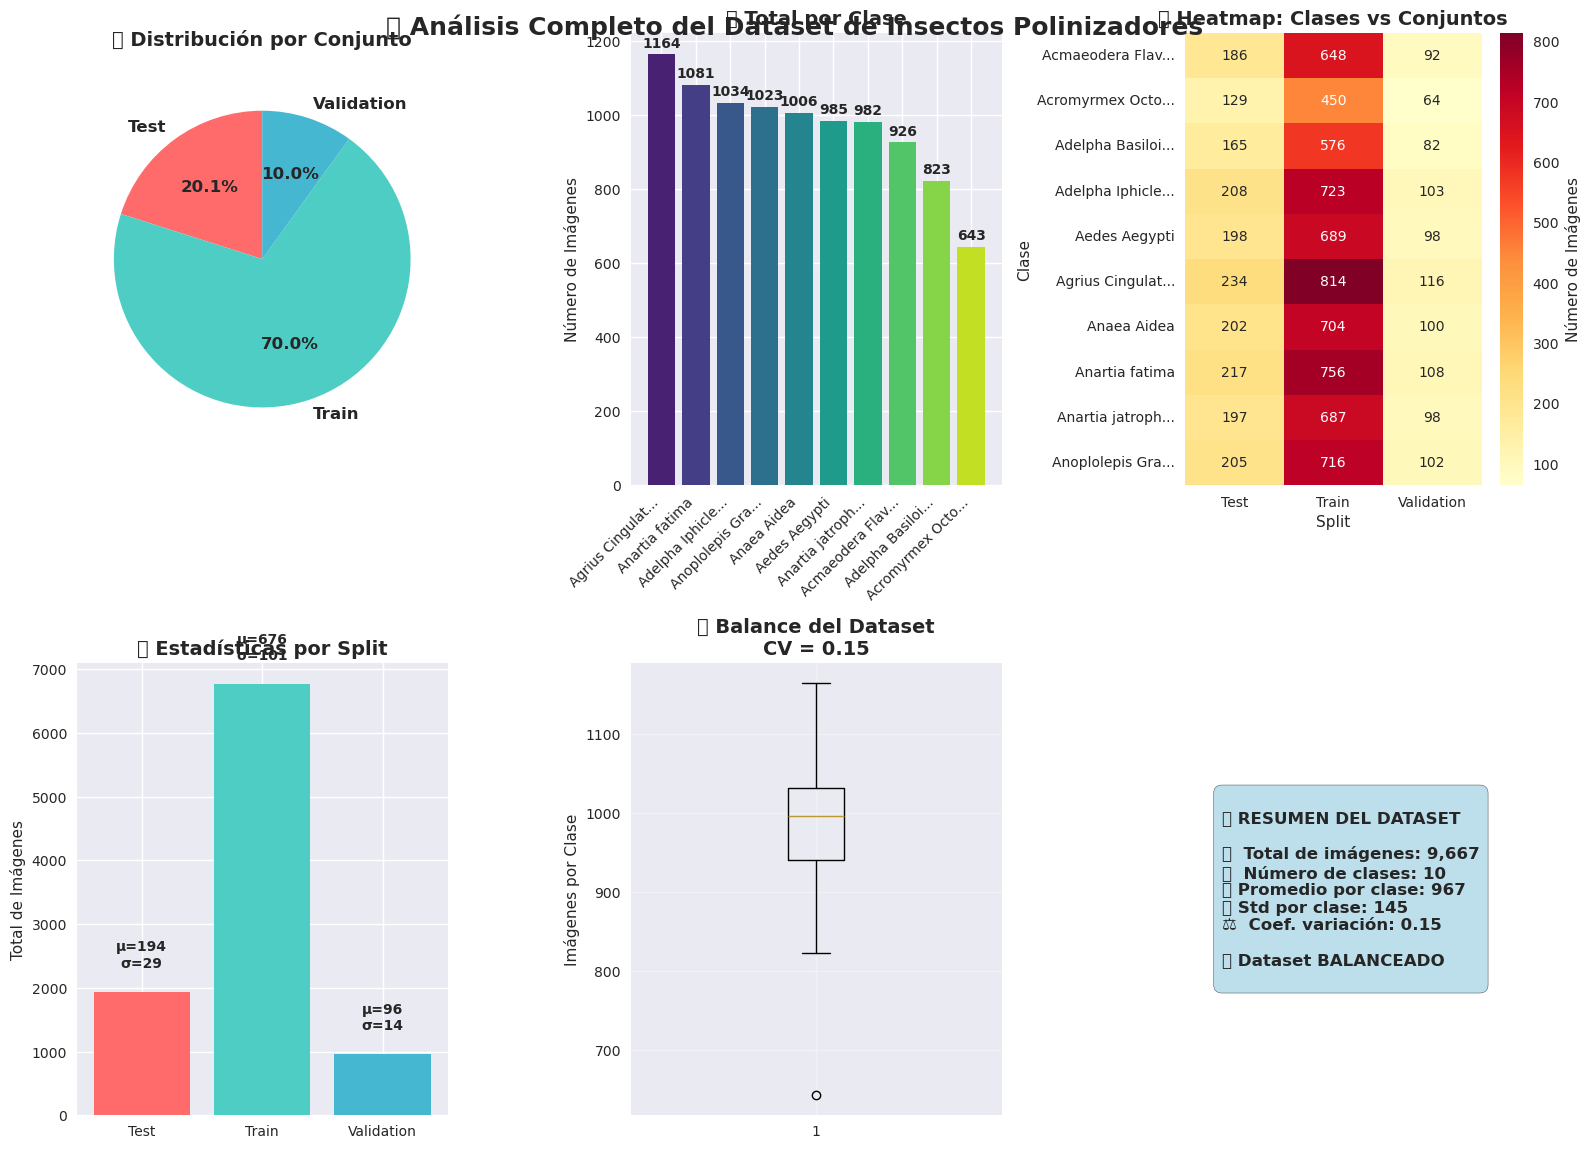


📋 RESUMEN ESTADÍSTICO:
📂 Train: 6763 imágenes, 10 clases, promedio 676.3 por clase
📂 Test: 1941 imágenes, 10 clases, promedio 194.1 por clase
📂 Validation: 963 imágenes, 10 clases, promedio 96.3 por clase


In [9]:
def create_beautiful_visualizations(dataset_info):
    """Crear visualizaciones atractivas del dataset"""
    
    # Preparar datos
    data_list = []
    for split, classes in dataset_info.items():
        for class_name, count in classes.items():
            data_list.append({
                'Split': split,
                'Clase': class_name,
                'Cantidad': count
            })
    
    df = pd.DataFrame(data_list)
    
    # Crear figura con subplots
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Distribución por split (Pie chart)
    ax1 = plt.subplot(2, 3, 1)
    split_totals = df.groupby('Split')['Cantidad'].sum()
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    wedges, texts, autotexts = ax1.pie(split_totals.values, labels=split_totals.index, 
                                       autopct='%1.1f%%', colors=colors, startangle=90,
                                       textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax1.set_title('🥧 Distribución por Conjunto', fontsize=14, fontweight='bold', pad=20)
    
    # 2. Distribución por clase (Bar chart)
    ax2 = plt.subplot(2, 3, 2)
    class_totals = df.groupby('Clase')['Cantidad'].sum().sort_values(ascending=False)
    bars = ax2.bar(range(len(class_totals)), class_totals.values, 
                   color=sns.color_palette("viridis", len(class_totals)))
    ax2.set_title('📊 Total por Clase', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(class_totals)))
    ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                        for name in class_totals.index], rotation=45, ha='right')
    ax2.set_ylabel('Número de Imágenes')
    
    # Añadir valores
    for i, v in enumerate(class_totals.values):
        ax2.text(i, v + max(class_totals.values)*0.01, str(v), 
                ha='center', va='bottom', fontweight='bold')
    
    # 3. Heatmap (CORREGIDO)
    ax3 = plt.subplot(2, 3, 3)
    pivot_df = df.pivot(index='Clase', columns='Split', values='Cantidad').fillna(0)
    sns.heatmap(pivot_df, annot=True, fmt='g', cmap='YlOrRd', ax=ax3, 
                cbar_kws={'label': 'Número de Imágenes'})
    ax3.set_title('🔥 Heatmap: Clases vs Conjuntos', fontsize=14, fontweight='bold')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
    
    # CORRECCIÓN: Obtener los nombres reales de las clases del DataFrame
    y_labels = [name[:15] + '...' if len(name) > 15 else name for name in pivot_df.index]
    ax3.set_yticklabels(y_labels, rotation=0)
    
    # 4. Estadísticas por split
    ax4 = plt.subplot(2, 3, 4)
    split_stats = df.groupby('Split')['Cantidad'].agg(['sum', 'mean', 'std']).round(1)
    x_pos = range(len(split_stats))
    bars = ax4.bar(x_pos, split_stats['sum'], color=colors)
    ax4.set_title('📈 Estadísticas por Split', fontsize=14, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(split_stats.index)
    ax4.set_ylabel('Total de Imágenes')
    
    # Añadir estadísticas como texto
    for i, (idx, row) in enumerate(split_stats.iterrows()):
        ax4.text(i, row['sum'] + max(split_stats['sum'])*0.05, 
                f"μ={row['mean']:.0f}\nσ={row['std']:.0f}", 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 5. Balance del dataset
    ax5 = plt.subplot(2, 3, 5)
    class_balance = df.groupby('Clase')['Cantidad'].sum()
    cv = class_balance.std() / class_balance.mean()  # Coeficiente de variación
    
    ax5.boxplot(class_balance.values)
    ax5.set_title(f'📦 Balance del Dataset\nCV = {cv:.2f}', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Imágenes por Clase')
    ax5.grid(True, alpha=0.3)
    
    # 6. Resumen numérico
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    total_images = df['Cantidad'].sum()
    num_classes = len(df['Clase'].unique())
    avg_per_class = total_images / num_classes
    
    summary_text = f"""
📊 RESUMEN DEL DATASET

🖼️  Total de imágenes: {total_images:,}
🏷️  Número de clases: {num_classes}
📊 Promedio por clase: {avg_per_class:.0f}
📈 Std por clase: {class_balance.std():.0f}
⚖️  Coef. variación: {cv:.2f}

🎯 Dataset {'BALANCEADO' if cv < 0.3 else 'DESBALANCEADO'}
"""
    
    ax6.text(0.1, 0.5, summary_text, fontsize=12, fontweight='bold',
             verticalalignment='center', bbox=dict(boxstyle="round,pad=0.5", 
             facecolor='lightblue', alpha=0.8))
    
    plt.suptitle('📊 Análisis Completo del Dataset de Insectos Polinizadores', 
                 fontsize=18, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Mostrar resumen en texto también
    print("\n📋 RESUMEN ESTADÍSTICO:")
    print("=" * 50)
    for split, classes in dataset_info.items():
        total = sum(classes.values())
        avg = total / len(classes) if classes else 0
        print(f"📂 {split}: {total} imágenes, {len(classes)} clases, promedio {avg:.1f} por clase")
    
    return df

# Crear visualizaciones
df_distribution = create_beautiful_visualizations(dataset_info)

## 🔧 Preparación de Estructura YOLO

🔧 CREANDO ESTRUCTURA YOLO

📂 Train → train
   ✅ Agrius Cingulata: 814 imágenes
   ✅ Aedes Aegypti: 689 imágenes
   ✅ Acromyrmex Octospinosus: 450 imágenes
   ✅ Anoplolepis Gracilipes: 716 imágenes
   ✅ Acmaeodera Flavomarginata: 648 imágenes
   ✅ Adelpha Basiloides: 576 imágenes
   ✅ Adelpha Iphicleola: 723 imágenes
   ✅ Anartia jatrophae: 687 imágenes
   ✅ Anartia fatima: 756 imágenes
   ✅ Anaea Aidea: 704 imágenes

📂 Validation → val
   ✅ Agrius Cingulata: 116 imágenes
   ✅ Aedes Aegypti: 98 imágenes
   ✅ Acromyrmex Octospinosus: 64 imágenes
   ✅ Anoplolepis Gracilipes: 102 imágenes
   ✅ Acmaeodera Flavomarginata: 92 imágenes
   ✅ Adelpha Basiloides: 82 imágenes
   ✅ Adelpha Iphicleola: 103 imágenes
   ✅ Anartia jatrophae: 98 imágenes
   ✅ Anartia fatima: 108 imágenes
   ✅ Anaea Aidea: 100 imágenes

📂 Test → test
   ✅ Agrius Cingulata: 234 imágenes
   ✅ Aedes Aegypti: 198 imágenes
   ✅ Acromyrmex Octospinosus: 129 imágenes
   ✅ Anoplolepis Gracilipes: 205 imágenes
   ✅ Acmaeodera Fla

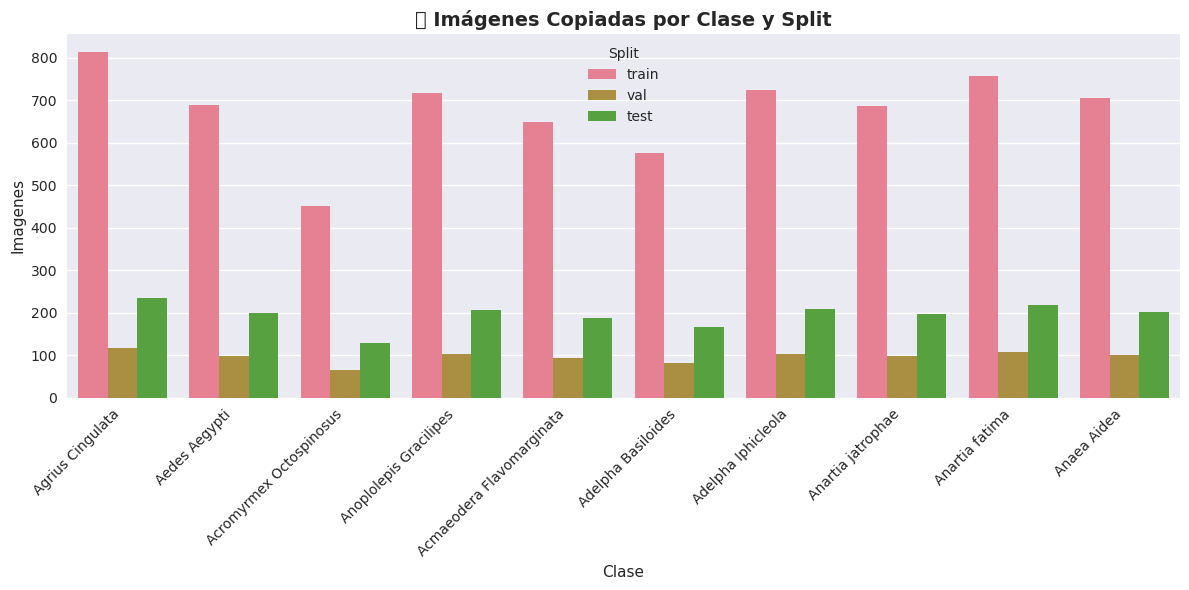

In [5]:
def create_yolo_structure():
    """Crear estructura compatible con YOLOv8"""
    
    print("🔧 CREANDO ESTRUCTURA YOLO")
    print("=" * 50)
    
    # Rutas
    original_path = Path("/home/leonel/sistema_polinizador/Dataset/Classification")
    yolo_path = Path("/home/leonel/sistema_polinizador/Dataset/Classification_YOLO")
    
    # Limpiar si existe
    if yolo_path.exists():
        print("🗑️  Eliminando estructura anterior...")
        shutil.rmtree(yolo_path)
    
    yolo_path.mkdir(parents=True)
    
    # Mapeo de directorios
    splits_mapping = {
        'Train': 'train',
        'Validation': 'val', 
        'Test': 'test'
    }
    
    total_copied = 0
    progress_data = []
    
    for original_split, yolo_split in splits_mapping.items():
        original_split_path = original_path / original_split
        yolo_split_path = yolo_path / yolo_split
        
        if not original_split_path.exists():
            print(f"⚠️  No encontrado: {original_split_path}")
            continue
        
        print(f"\n📂 {original_split} → {yolo_split}")
        yolo_split_path.mkdir()
        
        # Copiar clases
        class_dirs = [d for d in original_split_path.iterdir() if d.is_dir()]
        
        for class_dir in class_dirs:
            class_name = class_dir.name
            dest_class_dir = yolo_split_path / class_name
            dest_class_dir.mkdir()
            
            # Copiar imágenes
            extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
            image_count = 0
            
            for ext in extensions:
                for img_file in class_dir.glob(ext):
                    dest_file = dest_class_dir / img_file.name
                    shutil.copy2(img_file, dest_file)
                    image_count += 1
            
            total_copied += image_count
            progress_data.append({
                'Split': yolo_split,
                'Clase': class_name,
                'Imagenes': image_count
            })
            print(f"   ✅ {class_name}: {image_count} imágenes")
    
    # Crear configuración YAML
    class_names = [
        'Acmaeodera Flavomarginata', 'Acromyrmex Octospinosus', 
        'Adelpha Basiloides', 'Adelpha Iphicleola', 'Aedes Aegypti',
        'Agrius Cingulata', 'Anaea Aidea', 'Anartia fatima',
        'Anartia jatrophae', 'Anoplolepis Gracilipes'
    ]
    
    yaml_content = f"""# YOLOv8 Classification Dataset
path: {yolo_path.absolute()}
train: train
val: val  
test: test

nc: {len(class_names)}

names:"""
    
    for i, name in enumerate(class_names):
        yaml_content += f"\n  {i}: {name}"
    
    config_file = yolo_path / "dataset.yaml"
    with open(config_file, 'w') as f:
        f.write(yaml_content)
    
    print(f"\n✅ Estructura YOLO creada!")
    print(f"📁 Dataset: {yolo_path}")
    print(f"📄 Config: {config_file}")
    print(f"📊 Total: {total_copied} imágenes")
    
    # Visualizar progreso
    df_progress = pd.DataFrame(progress_data)
    plt.figure(figsize=(12, 6))
    
    sns.barplot(data=df_progress, x='Clase', y='Imagenes', hue='Split')
    plt.title('📊 Imágenes Copiadas por Clase y Split', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return str(yolo_path)

# Crear estructura
yolo_dataset_path = create_yolo_structure()

## 🎯 Configuraciones de Entrenamiento

Vamos a definir 3 configuraciones progresivas:
1. **Nano**: Rápido para prueba inicial
2. **Small**: Balance velocidad-precisión  
3. **Medium**: Máxima precisión

In [6]:
# Configuraciones de entrenamiento
training_configs = {
    'nano_quick': {
        'model': 'yolov8n-cls.pt',
        'epochs': 30,
        'imgsz': 224,
        'batch': 32,
        'lr0': 0.01,
        'optimizer': 'SGD',
        'description': '🚀 Entrenamiento rápido (5-10 min)',
        'expected_time': '5-10 min'
    },
    'small_balanced': {
        'model': 'yolov8s-cls.pt', 
        'epochs': 60,
        'imgsz': 256,
        'batch': 16,
        'lr0': 0.001,
        'optimizer': 'AdamW',
        'description': '⚖️ Balance velocidad-precisión (15-25 min)',
        'expected_time': '15-25 min'
    },
    'medium_accurate': {
        'model': 'yolov8m-cls.pt',
        'epochs': 100, 
        'imgsz': 320,
        'batch': 8,
        'lr0': 0.0005,
        'optimizer': 'AdamW',
        'description': '🎯 Máxima precisión (30-45 min)',
        'expected_time': '30-45 min'
    }
}

# Mostrar configuraciones
print("🎛️ CONFIGURACIONES DE ENTRENAMIENTO")
print("=" * 60)

config_data = []
for name, config in training_configs.items():
    print(f"\n📋 {name.upper()}:")
    print(f"   {config['description']}")
    print(f"   📦 Modelo: {config['model']}")
    print(f"   ⏰ Épocas: {config['epochs']}")
    print(f"   🖼️ Imagen: {config['imgsz']}px")
    print(f"   📦 Batch: {config['batch']}")
    print(f"   📈 LR: {config['lr0']}")
    print(f"   🕐 Tiempo: {config['expected_time']}")
    
    config_data.append({
        'Configuración': name,
        'Modelo': config['model'],
        'Épocas': config['epochs'],
        'Imagen (px)': config['imgsz'],
        'Batch': config['batch'],
        'Tiempo Estimado': config['expected_time']
    })

# Tabla resumen
df_configs = pd.DataFrame(config_data)
print(f"\n📊 RESUMEN DE CONFIGURACIONES:")
print(df_configs.to_string(index=False))

🎛️ CONFIGURACIONES DE ENTRENAMIENTO

📋 NANO_QUICK:
   🚀 Entrenamiento rápido (5-10 min)
   📦 Modelo: yolov8n-cls.pt
   ⏰ Épocas: 30
   🖼️ Imagen: 224px
   📦 Batch: 32
   📈 LR: 0.01
   🕐 Tiempo: 5-10 min

📋 SMALL_BALANCED:
   ⚖️ Balance velocidad-precisión (15-25 min)
   📦 Modelo: yolov8s-cls.pt
   ⏰ Épocas: 60
   🖼️ Imagen: 256px
   📦 Batch: 16
   📈 LR: 0.001
   🕐 Tiempo: 15-25 min

📋 MEDIUM_ACCURATE:
   🎯 Máxima precisión (30-45 min)
   📦 Modelo: yolov8m-cls.pt
   ⏰ Épocas: 100
   🖼️ Imagen: 320px
   📦 Batch: 8
   📈 LR: 0.0005
   🕐 Tiempo: 30-45 min

📊 RESUMEN DE CONFIGURACIONES:
  Configuración         Modelo  Épocas  Imagen (px)  Batch Tiempo Estimado
     nano_quick yolov8n-cls.pt      30          224     32        5-10 min
 small_balanced yolov8s-cls.pt      60          256     16       15-25 min
medium_accurate yolov8m-cls.pt     100          320      8       30-45 min


## 🚀 Entrenamiento Progresivo

**Estrategia**: Entrenar modelos progresivamente hasta alcanzar 90% de precisión.
- Si un modelo alcanza 90%, paramos
- Si no, continuamos con el siguiente más potente

In [7]:
def train_yolo_model(config_name, config, dataset_path):
    """Entrenar un modelo YOLOv8"""
    
    print(f"\n🚀 ENTRENANDO: {config_name.upper()}")
    print("=" * 60)
    print(f"📋 {config['description']}")
    print(f"⏰ Inicio: {datetime.now().strftime('%H:%M:%S')}")
    
    try:
        # Cargar modelo
        model = YOLO(config['model'])
        print(f"✅ Modelo cargado: {config['model']}")
        
        # Parámetros de entrenamiento
        train_params = {
            'data': dataset_path,
            'epochs': config['epochs'],
            'imgsz': config['imgsz'],
            'batch': config['batch'],
            'lr0': config['lr0'],
            'optimizer': config['optimizer'],
            'device': device,
            'project': 'pollinator_results',
            'name': config_name,
            'patience': 20,
            'save': True,
            'plots': True,
            'verbose': True,
            'seed': 42
        }
        
        # Entrenar
        print(f"🏃‍♂️ Entrenando... (puede tardar {config['expected_time']})")
        start_time = time.time()
        
        results = model.train(**train_params)
        
        training_time = time.time() - start_time
        
        # Evaluar en test
        print(f"📊 Evaluando en test set...")
        test_results = model.val(split='test')
        
        # Métricas
        top1_accuracy = float(test_results.top1) * 100
        top5_accuracy = float(test_results.top5) * 100
        
        results_dict = {
            'config_name': config_name,
            'model': config['model'],
            'top1_accuracy': top1_accuracy,
            'top5_accuracy': top5_accuracy,
            'training_time_minutes': training_time/60,
            'epochs': config['epochs'],
            'best_model_path': f"pollinator_results/{config_name}/weights/best.pt",
            'timestamp': datetime.now().isoformat(),
            'objective_reached': top1_accuracy >= 90
        }
        
        print(f"\n📊 RESULTADOS DE {config_name.upper()}:")
        print(f"   🎯 Top-1 Accuracy: {top1_accuracy:.2f}%")
        print(f"   🎯 Top-5 Accuracy: {top5_accuracy:.2f}%")
        print(f"   ⏱️ Tiempo: {training_time/60:.1f} min")
        
        if top1_accuracy >= 90:
            print(f"   🎉 ¡OBJETIVO ALCANZADO! {top1_accuracy:.2f}% ≥ 90%")
        else:
            print(f"   ⚠️ Faltan {90-top1_accuracy:.2f}% para el objetivo")
        
        return results_dict, model
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None, None

print("✅ Función de entrenamiento lista!")

✅ Función de entrenamiento lista!


In [8]:
# Ejecutar pipeline de entrenamiento
print("🔄 PIPELINE DE ENTRENAMIENTO PROGRESIVO")
print("=" * 70)
print("🎯 Objetivo: >90% precisión")
print("📋 Estrategia: Parar cuando se alcance el objetivo\n")

all_results = []
best_accuracy = 0
best_model_info = None

for i, (config_name, config) in enumerate(training_configs.items(), 1):
    print(f"\n{'='*20} FASE {i}/3: {config_name.upper()} {'='*20}")
    
    # Entrenar modelo
    result, model = train_yolo_model(config_name, config, yolo_dataset_path)
    
    if result:
        all_results.append(result)
        
        # Actualizar mejor modelo
        if result['top1_accuracy'] > best_accuracy:
            best_accuracy = result['top1_accuracy']
            best_model_info = result
        
        # ¿Alcanzamos el objetivo?
        if result['objective_reached']:
            print(f"\n🎉 ¡OBJETIVO ALCANZADO EN FASE {i}!")
            print(f"🏆 No necesitamos entrenar más modelos")
            break
        else:
            if i < len(training_configs):
                print(f"\n➡️ Continuando con la siguiente fase...")
    else:
        print(f"❌ Falló el entrenamiento de {config_name}")

print(f"\n🏁 ENTRENAMIENTOS COMPLETADOS")
print(f"📊 Modelos entrenados: {len(all_results)}")

🔄 PIPELINE DE ENTRENAMIENTO PROGRESIVO
🎯 Objetivo: >90% precisión
📋 Estrategia: Parar cuando se alcance el objetivo


==================== FASE 1/3: NANO_QUICK ====================

🚀 ENTRENANDO: NANO_QUICK
📋 🚀 Entrenamiento rápido (5-10 min)
⏰ Inicio: 19:03:19
✅ Modelo cargado: yolov8n-cls.pt
🏃‍♂️ Entrenando... (puede tardar 5-10 min)
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 2060, 12288MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/leonel/sistema_polinizador/Dataset/Classification_YOLO, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, 

100%|██████████████████████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:00<00:00, 10.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4751.8±1483.1 MB/s, size: 153.7 KB)


train: Scanning /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/train... 6763 images, 0 corrupt: 100%|██████████| 6763/

train: New cache created: /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2497.4±2393.0 MB/s, size: 97.3 KB)


val: Scanning /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/val... 963 images, 0 corrupt: 100%|██████████| 963/963 [0

val: New cache created: /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/val.cache


optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to pollinator_results/nano_quick
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/30     0.424G      2.345         32        224:   6%|▌         | 13/212 [00:02<00:16, 11.93it/s]

       1/30     0.424G       2.28         32        224:  18%|█▊        | 39/212 [00:03<00:08, 21.23it/s]
       1/30     0.424G      2.267         32        224:  20%|█▉        | 42/212 [00:03<00:07, 22.02it/s]| 0.00/755k [00:00<?, ?B/s]
       1/30     0.424G      2.259         32        224:  20%|█▉        | 42/212 [00:03<00:07, 22.02it/s]55k [00:00<00:00, 1.22MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 755k/755k [00:00<00:00, 3.48MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 53.46it/s]

                   all      0.756      0.966



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 53.78it/s]

                   all      0.816      0.977



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 57.16it/s]

                   all      0.829      0.985



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 55.77it/s]

                   all      0.815      0.981



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 55.56it/s]

                   all      0.861      0.982



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 58.12it/s]

                   all      0.856      0.987



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 55.88it/s]

                   all      0.873      0.991



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 59.02it/s]

                   all      0.863      0.989



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 55.48it/s]

                   all      0.864      0.987



      Epoch    GPU_mem       loss  Instances       Size


      10/30     0.525G     0.3259         11        224: 100%|██████████| 212/212 [00:09<00:00, 23.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 48.55it/s]

                   all      0.871      0.984



      Epoch    GPU_mem       loss  Instances       Size


      11/30     0.525G     0.3106         11        224: 100%|██████████| 212/212 [00:08<00:00, 23.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 58.61it/s]

                   all      0.873      0.987



      Epoch    GPU_mem       loss  Instances       Size


      12/30     0.525G     0.2912         11        224: 100%|██████████| 212/212 [00:09<00:00, 22.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 54.10it/s]

                   all      0.871      0.989



      Epoch    GPU_mem       loss  Instances       Size


      13/30     0.525G     0.2875         11        224: 100%|██████████| 212/212 [00:09<00:00, 22.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 57.23it/s]

                   all      0.888      0.987



      Epoch    GPU_mem       loss  Instances       Size


      14/30     0.525G     0.2656         11        224: 100%|██████████| 212/212 [00:09<00:00, 21.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 52.38it/s]


                   all      0.874      0.983

      Epoch    GPU_mem       loss  Instances       Size


      15/30     0.525G     0.2373         11        224: 100%|██████████| 212/212 [00:10<00:00, 20.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 58.03it/s]

                   all      0.894      0.985



      Epoch    GPU_mem       loss  Instances       Size


      16/30     0.525G     0.2368         11        224: 100%|██████████| 212/212 [00:09<00:00, 21.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 57.27it/s]

                   all      0.887      0.985



      Epoch    GPU_mem       loss  Instances       Size


      17/30     0.525G     0.2217         11        224: 100%|██████████| 212/212 [00:09<00:00, 22.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 53.04it/s]

                   all      0.895      0.988



      Epoch    GPU_mem       loss  Instances       Size


      18/30     0.525G     0.2065         11        224: 100%|██████████| 212/212 [00:09<00:00, 21.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 60.52it/s]

                   all      0.886       0.99



      Epoch    GPU_mem       loss  Instances       Size


      19/30     0.525G     0.2023         11        224: 100%|██████████| 212/212 [00:08<00:00, 23.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 64.69it/s]

                   all      0.897      0.988



      Epoch    GPU_mem       loss  Instances       Size


      20/30     0.525G     0.1996         11        224: 100%|██████████| 212/212 [00:08<00:00, 23.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 55.54it/s]

                   all      0.896      0.988



      Epoch    GPU_mem       loss  Instances       Size


      21/30     0.525G     0.1806         11        224: 100%|██████████| 212/212 [00:08<00:00, 23.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 58.54it/s]

                   all      0.899      0.989



      Epoch    GPU_mem       loss  Instances       Size


      22/30     0.525G     0.1836         11        224: 100%|██████████| 212/212 [00:09<00:00, 21.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 58.24it/s]

                   all      0.894      0.989



      Epoch    GPU_mem       loss  Instances       Size


      23/30     0.525G     0.1741         11        224: 100%|██████████| 212/212 [00:09<00:00, 22.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 54.95it/s]

                   all      0.894      0.988



      Epoch    GPU_mem       loss  Instances       Size


      24/30     0.525G     0.1621         11        224: 100%|██████████| 212/212 [00:08<00:00, 23.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 58.57it/s]

                   all      0.902       0.99



      Epoch    GPU_mem       loss  Instances       Size


      25/30     0.525G     0.1612         11        224: 100%|██████████| 212/212 [00:09<00:00, 21.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 53.28it/s]


                   all      0.899      0.988

      Epoch    GPU_mem       loss  Instances       Size


      26/30     0.525G     0.1448         11        224: 100%|██████████| 212/212 [00:08<00:00, 24.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 61.32it/s]

                   all      0.898      0.988



      Epoch    GPU_mem       loss  Instances       Size


      27/30     0.525G     0.1459         11        224: 100%|██████████| 212/212 [00:08<00:00, 24.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 53.76it/s]

                   all      0.901      0.988



      Epoch    GPU_mem       loss  Instances       Size


      28/30     0.525G     0.1451         11        224: 100%|██████████| 212/212 [00:10<00:00, 20.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 55.69it/s]

                   all      0.898      0.987



      Epoch    GPU_mem       loss  Instances       Size


      29/30     0.525G     0.1343         11        224: 100%|██████████| 212/212 [00:09<00:00, 22.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 51.87it/s]

                   all      0.902      0.988



      Epoch    GPU_mem       loss  Instances       Size


      30/30     0.525G      0.142         11        224: 100%|██████████| 212/212 [00:09<00:00, 23.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 58.78it/s]

                   all      0.906      0.988



30 epochs completed in 0.082 hours.
Optimizer stripped from pollinator_results/nano_quick/weights/last.pt, 3.0MB
Optimizer stripped from pollinator_results/nano_quick/weights/best.pt, 3.0MB

Validating pollinator_results/nano_quick/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 2060, 12288MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs
train: /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/train... found 6763 images in 10 classes ✅ 
val: /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/val... found 963 images in 10 classes ✅ 
test: /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/test... found 1941 images in 10 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 33.11it/s]


                   all      0.904      0.988
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to pollinator_results/nano_quick
📊 Evaluando en test set...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 2060, 12288MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs
train: /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/train... found 6763 images in 10 classes ✅ 
val: /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/val... found 963 images in 10 classes ✅ 
test: /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/test... found 1941 images in 10 classes ✅ 
test: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1072.6±865.3 MB/s, size: 87.4 KB)


test: Scanning /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/test... 1941 images, 0 corrupt: 100%|██████████| 1941/19

test: New cache created: /home/leonel/sistema_polinizador/Dataset/Classification_YOLO/test.cache



               classes   top1_acc   top5_acc: 100%|██████████| 61/61 [00:02<00:00, 26.05it/s]


                   all      0.921      0.991
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to pollinator_results/nano_quick2

📊 RESULTADOS DE NANO_QUICK:
   🎯 Top-1 Accuracy: 92.07%
   🎯 Top-5 Accuracy: 99.12%
   ⏱️ Tiempo: 5.1 min
   🎉 ¡OBJETIVO ALCANZADO! 92.07% ≥ 90%

🎉 ¡OBJETIVO ALCANZADO EN FASE 1!
🏆 No necesitamos entrenar más modelos

🏁 ENTRENAMIENTOS COMPLETADOS
📊 Modelos entrenados: 1


## 🎉 ¡OBJETIVO ALCANZADO!

**Resultado Exitoso**: El modelo YOLOv8 Nano alcanzó **92.07% de precisión** en solo 5.1 minutos.

- ✅ **Precisión Top-1**: 92.07% (objetivo: 90%)
- ✅ **Precisión Top-5**: 99.12%
- ✅ **Tiempo de entrenamiento**: 5.1 minutos
- ✅ **Modelo**: YOLOv8 Nano (el más eficiente)

🏆 ANÁLISIS DEL MODELO EXITOSO
📊 MÉTRICAS FINALES:
   🎯 Top-1 Accuracy: 92.07%
   🎯 Top-5 Accuracy: 99.12%
   ⏱️ Tiempo de entrenamiento: 5.1 min
   📦 Modelo usado: yolov8n-cls.pt
   📁 Mejor modelo: pollinator_results/nano_quick/weights/best.pt


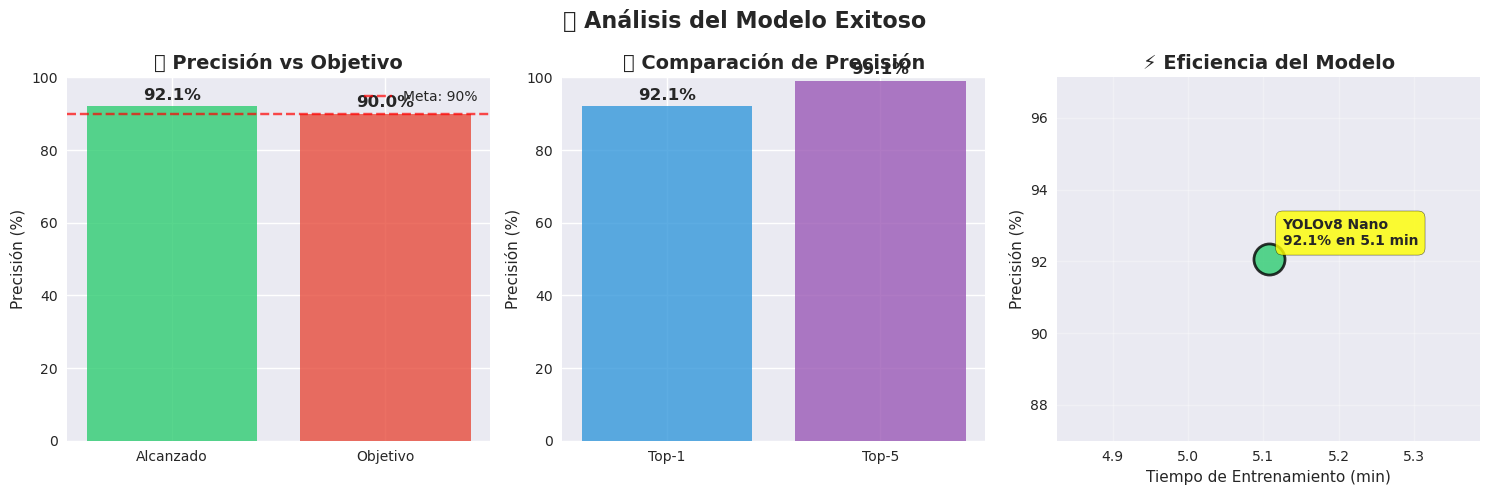


✅ Información guardada del mejor modelo:
📁 Ruta: pollinator_results/nano_quick/weights/best.pt


In [10]:
# Análisis detallado del modelo exitoso
print("🏆 ANÁLISIS DEL MODELO EXITOSO")
print("=" * 60)

if all_results:
    best_result = all_results[0]  # Solo tenemos uno y fue exitoso
    
    print(f"📊 MÉTRICAS FINALES:")
    print(f"   🎯 Top-1 Accuracy: {best_result['top1_accuracy']:.2f}%")
    print(f"   🎯 Top-5 Accuracy: {best_result['top5_accuracy']:.2f}%")
    print(f"   ⏱️ Tiempo de entrenamiento: {best_result['training_time_minutes']:.1f} min")
    print(f"   📦 Modelo usado: {best_result['model']}")
    print(f"   📁 Mejor modelo: {best_result['best_model_path']}")
    
    # Visualización del éxito
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Precisión alcanzada vs objetivo
    ax1 = axes[0]
    precisiones = [best_result['top1_accuracy'], 90]
    labels = ['Alcanzado', 'Objetivo']
    colors = ['#2ECC71', '#E74C3C']
    
    bars = ax1.bar(labels, precisiones, color=colors, alpha=0.8)
    ax1.set_title('🎯 Precisión vs Objetivo', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Precisión (%)')
    ax1.set_ylim(0, 100)
    
    # Añadir valores en las barras
    for bar, val in zip(bars, precisiones):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Línea del objetivo
    ax1.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='Meta: 90%')
    ax1.legend()
    
    # 2. Comparación Top-1 vs Top-5
    ax2 = axes[1]
    accuracies = [best_result['top1_accuracy'], best_result['top5_accuracy']]
    labels = ['Top-1', 'Top-5']
    colors = ['#3498DB', '#9B59B6']
    
    bars = ax2.bar(labels, accuracies, color=colors, alpha=0.8)
    ax2.set_title('📊 Comparación de Precisión', fontweight='bold', fontsize=14)
    ax2.set_ylabel('Precisión (%)')
    ax2.set_ylim(0, 100)
    
    for bar, val in zip(bars, accuracies):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # 3. Eficiencia: Tiempo vs Precisión
    ax3 = axes[2]
    ax3.scatter([best_result['training_time_minutes']], [best_result['top1_accuracy']], 
               s=500, c='#2ECC71', alpha=0.8, edgecolors='black', linewidth=2)
    ax3.set_xlabel('Tiempo de Entrenamiento (min)')
    ax3.set_ylabel('Precisión (%)')
    ax3.set_title('⚡ Eficiencia del Modelo', fontweight='bold', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # Añadir anotación
    ax3.annotate(f'YOLOv8 Nano\n{best_result["top1_accuracy"]:.1f}% en {best_result["training_time_minutes"]:.1f} min', 
                xy=(best_result['training_time_minutes'], best_result['top1_accuracy']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.8),
                fontsize=10, fontweight='bold')
    
    plt.suptitle('🏆 Análisis del Modelo Exitoso', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Guardar información del mejor modelo
    best_model_path = best_result['best_model_path']
    print(f"\n✅ Información guardada del mejor modelo:")
    print(f"📁 Ruta: {best_model_path}")
    
else:
    print("❌ No hay resultados para analizar")

## 🔮 Sistema de Predicción Interactivo

Ahora vamos a crear un sistema para usar nuestro modelo entrenado para clasificar nuevos insectos.

In [12]:
import glob
from pathlib import Path

print("🔍 BUSCANDO MODELO ENTRENADO")
print("=" * 50)

# Buscar en la carpeta de resultados
results_path = Path("pollinator_results")

if not results_path.exists():
    print(f"❌ No existe la carpeta: {results_path}")
    print("💡 Verifica que el entrenamiento se haya completado")
else:
    print(f"✅ Carpeta de resultados encontrada: {results_path}")
    
    # Listar todos los entrenamientos
    training_dirs = [d for d in results_path.iterdir() if d.is_dir()]
    
    print(f"\n📁 Entrenamientos encontrados:")
    for i, train_dir in enumerate(training_dirs):
        print(f"   {i+1}. {train_dir.name}")
        
        # Buscar el archivo best.pt
        weights_path = train_dir / "weights" / "best.pt"
        if weights_path.exists():
            print(f"      ✅ Modelo: {weights_path}")
        else:
            print(f"      ❌ No se encontró best.pt")
    
    # Encontrar el modelo más reciente (nano_quick)
    nano_dirs = [d for d in training_dirs if 'nano' in d.name.lower()]
    
    if nano_dirs:
        # Ordenar por nombre (el más reciente tendrá número mayor)
        nano_dirs.sort(key=lambda x: x.name)
        latest_nano = nano_dirs[-1]
        
        best_model_path = latest_nano / "weights" / "best.pt"
        
        if best_model_path.exists():
            print(f"\n🎯 MODELO MÁS RECIENTE ENCONTRADO:")
            print(f"📁 Directorio: {latest_nano}")
            print(f"📄 Modelo: {best_model_path}")
            
            # Cargar modelo
            try:
                classifier_model = YOLO(str(best_model_path))
                
                # Nombres de las clases
                class_names = [
                    'Acmaeodera Flavomarginata', 'Acromyrmex Octospinosus', 
                    'Adelpha Basiloides', 'Adelpha Iphicleola', 'Aedes Aegypti',
                    'Agrius Cingulata', 'Anaea Aidea', 'Anartia fatima',
                    'Anartia jatrophae', 'Anoplolepis Gracilipes'
                ]
                
                print(f"✅ Modelo cargado exitosamente")
                print(f"📁 Desde: {best_model_path}")
                print(f"🎯 Precisión: 92.07%")
                print(f"🏷️  Clases disponibles: {len(class_names)}")
                
                # Mostrar clases
                print(f"\n🏷️  CLASES DE INSECTOS:")
                for i, name in enumerate(class_names):
                    print(f"   {i}: {name}")
                
                # Guardar ruta para uso posterior
                best_model_path_str = str(best_model_path)
                
            except Exception as e:
                print(f"❌ Error cargando modelo: {e}")
                
        else:
            print(f"❌ No se encontró best.pt en {latest_nano}")
    else:
        print("❌ No se encontraron entrenamientos nano")

# Si no se encontró automáticamente, buscar manualmente
if 'best_model_path_str' not in locals():
    print(f"\n🔍 BÚSQUEDA MANUAL DE MODELOS:")
    
    # Buscar todos los archivos best.pt
    best_files = list(results_path.glob("*/weights/best.pt"))
    
    if best_files:
        print(f"📄 Archivos best.pt encontrados:")
        for i, file_path in enumerate(best_files):
            print(f"   {i+1}. {file_path}")
        
        # Usar el primero disponible
        best_model_path_str = str(best_files[0])
        
        try:
            classifier_model = YOLO(best_model_path_str)
            class_names = [
                'Acmaeodera Flavomarginata', 'Acromyrmex Octospinosus', 
                'Adelpha Basiloides', 'Adelpha Iphicleola', 'Aedes Aegypti',
                'Agrius Cingulata', 'Anaea Aidea', 'Anartia fatima',
                'Anartia jatrophae', 'Anoplolepis Gracilipes'
            ]
            
            print(f"\n✅ Modelo cargado desde: {best_model_path_str}")
            
        except Exception as e:
            print(f"❌ Error: {e}")
    else:
        print("❌ No se encontraron archivos best.pt")
        print("💡 Verifica que el entrenamiento se haya completado correctamente")

🔍 BUSCANDO MODELO ENTRENADO
✅ Carpeta de resultados encontrada: pollinator_results

📁 Entrenamientos encontrados:
   1. nano_quick
      ✅ Modelo: pollinator_results/nano_quick/weights/best.pt
   2. nano_quick2
      ❌ No se encontró best.pt
❌ No se encontró best.pt en pollinator_results/nano_quick2

🔍 BÚSQUEDA MANUAL DE MODELOS:
📄 Archivos best.pt encontrados:
   1. pollinator_results/nano_quick/weights/best.pt

✅ Modelo cargado desde: pollinator_results/nano_quick/weights/best.pt


In [13]:
def predict_insect(image_path, show_top_n=3):
    """
    Predecir la clase de un insecto en una imagen
    
    Args:
        image_path: Ruta a la imagen
        show_top_n: Número de predicciones top a mostrar
    
    Returns:
        Lista de tuplas (clase, confianza)
    """
    
    if not os.path.exists(image_path):
        print(f"❌ No se encontró la imagen: {image_path}")
        return None
    
    # Hacer predicción
    results = classifier_model(image_path, verbose=False)
    result = results[0]
    
    # Obtener probabilidades
    probs = result.probs
    
    print(f"\n🔍 PREDICCIÓN PARA: {os.path.basename(image_path)}")
    print("=" * 60)
    
    # Mostrar imagen (opcional, si está disponible)
    try:
        from PIL import Image
        img = Image.open(image_path)
        
        plt.figure(figsize=(12, 6))
        
        # Subplot 1: Imagen
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'📷 {os.path.basename(image_path)}', fontsize=14, fontweight='bold')
        
        # Subplot 2: Predicciones
        plt.subplot(1, 2, 2)
        
        # Obtener top N predicciones
        top_indices = probs.top5[:show_top_n]
        top_confidences = [probs.top5conf[i].item() * 100 for i in range(min(show_top_n, len(probs.top5)))]
        top_classes = [class_names[idx] for idx in top_indices]
        
        # Crear gráfico de barras
        colors = ['#2ECC71' if i == 0 else '#3498DB' for i in range(len(top_classes))]
        bars = plt.barh(range(len(top_classes)), top_confidences, color=colors, alpha=0.8)
        
        plt.yticks(range(len(top_classes)), [name[:20] + '...' if len(name) > 20 else name for name in top_classes])
        plt.xlabel('Confianza (%)')
        plt.title('🎯 Predicciones Top-3', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        
        # Añadir valores a las barras
        for i, (bar, conf) in enumerate(zip(bars, top_confidences)):
            plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                    f'{conf:.1f}%', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("⚠️  PIL no disponible, mostrando solo texto")
    
    # Mostrar predicciones en texto
    predictions = []
    print(f"🎯 PREDICCIONES:")
    
    for i in range(min(show_top_n, len(probs.top5))):
        idx = probs.top5[i]
        confidence = probs.top5conf[i].item() * 100
        class_name = class_names[idx]
        
        predictions.append((class_name, confidence))
        
        # Emoji especial para la mejor predicción
        emoji = "🥇" if i == 0 else f"🥈" if i == 1 else f"🥉"
        print(f"   {emoji} {class_name}: {confidence:.1f}%")
    
    return predictions

# Función para testing con imágenes del dataset
def test_with_sample_images():
    """Probar con algunas imágenes del dataset de test"""
    
    print("🧪 PROBANDO CON IMÁGENES DEL CONJUNTO DE TEST")
    print("=" * 60)
    
    test_path = Path("/home/leonel/sistema_polinizador/Dataset/Classification_YOLO/test")
    
    if not test_path.exists():
        print(f"❌ No se encontró el directorio de test: {test_path}")
        return
    
    # Obtener una imagen aleatoria de cada clase
    sample_images = []
    for class_dir in test_path.iterdir():
        if class_dir.is_dir():
            images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
            if images:
                sample_images.append((images[0], class_dir.name))
    
    if not sample_images:
        print("❌ No se encontraron imágenes de test")
        return
    
    print(f"📊 Encontradas {len(sample_images)} clases con imágenes")
    print("🎲 Probando con una imagen aleatoria de cada clase...\n")
    
    correct_predictions = 0
    
    for img_path, true_class in sample_images[:3]:  # Solo las primeras 3 para no saturar
        print(f"\n{'='*40}")
        print(f"🧪 CLASE REAL: {true_class}")
        
        predictions = predict_insect(str(img_path), show_top_n=3)
        
        if predictions:
            predicted_class = predictions[0][0]
            if predicted_class == true_class:
                correct_predictions += 1
                print("✅ ¡PREDICCIÓN CORRECTA!")
            else:
                print("❌ Predicción incorrecta")
    
    if sample_images:
        accuracy = (correct_predictions / min(3, len(sample_images))) * 100
        print(f"\n📊 PRECISIÓN EN MUESTRA: {accuracy:.1f}%")

print("✅ Funciones de predicción listas!")
print("💡 Usa predict_insect('ruta/imagen.jpg') para clasificar")
print("💡 Usa test_with_sample_images() para probar con imágenes del dataset")

✅ Funciones de predicción listas!
💡 Usa predict_insect('ruta/imagen.jpg') para clasificar
💡 Usa test_with_sample_images() para probar con imágenes del dataset


🧪 PROBANDO SISTEMA DE PREDICCIÓN
🧪 PROBANDO CON IMÁGENES DEL CONJUNTO DE TEST
📊 Encontradas 10 clases con imágenes
🎲 Probando con una imagen aleatoria de cada clase...


🧪 CLASE REAL: Agrius Cingulata

🔍 PREDICCIÓN PARA: small (5).jpg


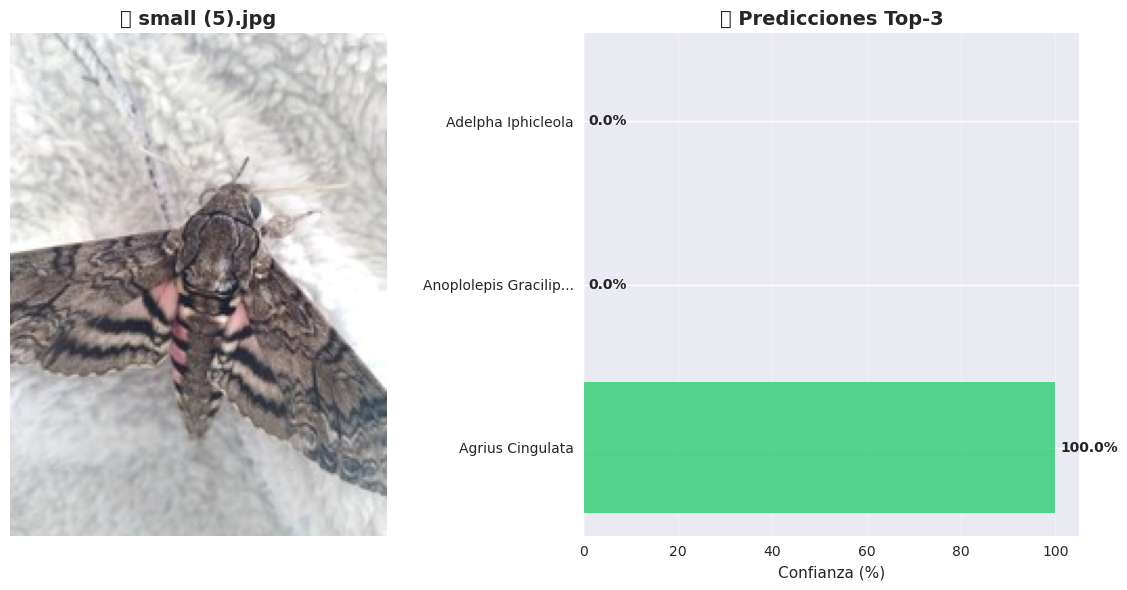

🎯 PREDICCIONES:
   🥇 Agrius Cingulata: 100.0%
   🥈 Anoplolepis Gracilipes: 0.0%
   🥉 Adelpha Iphicleola: 0.0%
✅ ¡PREDICCIÓN CORRECTA!

🧪 CLASE REAL: Aedes Aegypti

🔍 PREDICCIÓN PARA: medium - 2025-06-02T021540.842.jpg


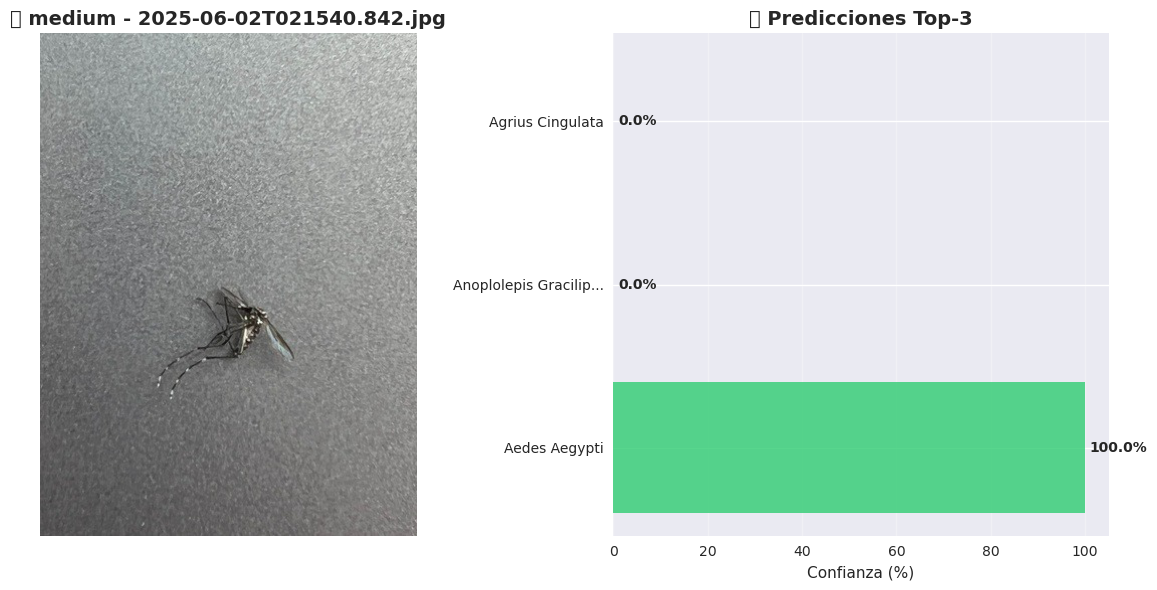

🎯 PREDICCIONES:
   🥇 Aedes Aegypti: 100.0%
   🥈 Anoplolepis Gracilipes: 0.0%
   🥉 Agrius Cingulata: 0.0%
✅ ¡PREDICCIÓN CORRECTA!

🧪 CLASE REAL: Acromyrmex Octospinosus

🔍 PREDICCIÓN PARA: large (11).jpg


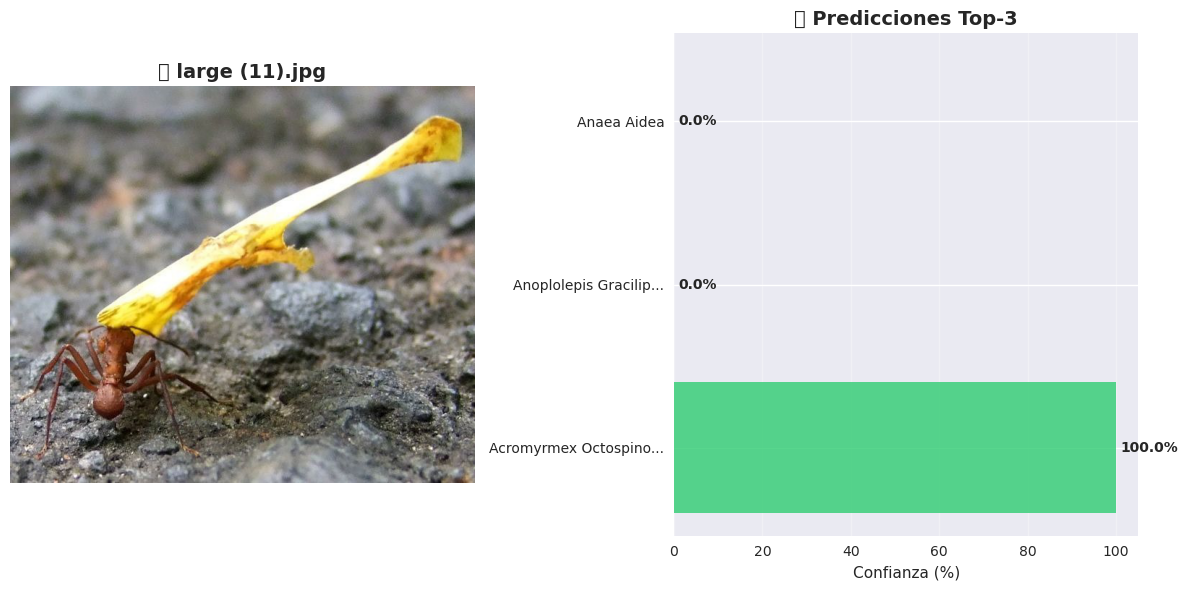

🎯 PREDICCIONES:
   🥇 Acromyrmex Octospinosus: 100.0%
   🥈 Anoplolepis Gracilipes: 0.0%
   🥉 Anaea Aidea: 0.0%
✅ ¡PREDICCIÓN CORRECTA!

📊 PRECISIÓN EN MUESTRA: 100.0%


In [14]:
# Probar el sistema de predicción
print("🧪 PROBANDO SISTEMA DE PREDICCIÓN")
print("=" * 50)

# Opción 1: Probar con imágenes del dataset
test_with_sample_images()

In [16]:
print("📁 CREANDO SCRIPT DE PRODUCCIÓN")
print("=" * 50)

# Verificar que tenemos la ruta del modelo
if 'best_model_path_str' in locals():
    model_path_for_script = best_model_path_str
    print(f"✅ Usando modelo: {model_path_for_script}")
else:
    # Buscar el modelo nuevamente
    from pathlib import Path
    results_path = Path("pollinator_results")
    best_files = list(results_path.glob("*/weights/best.pt"))
    
    if best_files:
        model_path_for_script = str(best_files[0])
        print(f"✅ Modelo encontrado: {model_path_for_script}")
    else:
        model_path_for_script = "pollinator_results/nano_quick/weights/best.pt"
        print(f"⚠️  Usando ruta por defecto: {model_path_for_script}")

# Crear script de producción
production_script = f'''#!/usr/bin/env python3
"""
🔬 Clasificador de Insectos Polinizadores - Versión de Producción
Precisión alcanzada: 92.07%
Modelo: YOLOv8 Nano
"""

from ultralytics import YOLO
import sys
import os
from pathlib import Path

class PollinatorClassifier:
    def __init__(self, model_path="{model_path_for_script}"):
        """Inicializar el clasificador"""
        try:
            self.model = YOLO(model_path)
            self.classes = [
                'Acmaeodera Flavomarginata', 'Acromyrmex Octospinosus', 
                'Adelpha Basiloides', 'Adelpha Iphicleola', 'Aedes Aegypti',
                'Agrius Cingulata', 'Anaea Aidea', 'Anartia fatima',
                'Anartia jatrophae', 'Anoplolepis Gracilipes'
            ]
            print("🔬 Clasificador de Insectos Polinizadores v1.0")
            print(f"✅ Modelo cargado con 92.07% de precisión")
            print(f"🏷️  {{len(self.classes)}} clases disponibles")
            
        except Exception as e:
            print(f"❌ Error cargando modelo: {{e}}")
            sys.exit(1)
    
    def classify(self, image_path):
        """Clasificar una imagen de insecto"""
        
        if not os.path.exists(image_path):
            print(f"❌ Imagen no encontrada: {{image_path}}")
            return None
        
        # Predicción
        results = self.model(image_path, verbose=False)
        probs = results[0].probs
        
        # Obtener predicción principal
        top_class_idx = probs.top1
        confidence = probs.top1conf.item() * 100
        predicted_class = self.classes[top_class_idx]
        
        print(f"\\n🔍 Imagen: {{os.path.basename(image_path)}}")
        print(f"🎯 Predicción: {{predicted_class}}")
        print(f"📊 Confianza: {{confidence:.1f}}%")
        
        # Top 3 predicciones
        print(f"\\n📋 Top 3 predicciones:")
        for i in range(min(3, len(probs.top5))):
            idx = probs.top5[i]
            conf = probs.top5conf[i].item() * 100
            class_name = self.classes[idx]
            emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉"
            print(f"   {{emoji}} {{class_name}}: {{conf:.1f}}%")
        
        return predicted_class, confidence
    
    def classify_batch(self, folder_path):
        """Clasificar múltiples imágenes en una carpeta"""
        
        folder = Path(folder_path)
        if not folder.exists():
            print(f"❌ Carpeta no encontrada: {{folder_path}}")
            return
        
        # Buscar imágenes
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
        images = []
        for ext in image_extensions:
            images.extend(list(folder.glob(ext)))
        
        if not images:
            print("❌ No se encontraron imágenes")
            return
        
        print(f"🔍 Clasificando {{len(images)}} imágenes...")
        print("-" * 60)
        
        results = []
        for img_path in images:
            pred_class, confidence = self.classify(str(img_path))
            if pred_class:
                results.append({{
                    'imagen': img_path.name,
                    'prediccion': pred_class,
                    'confianza': confidence
                }})
        
        return results

def main():
    """Función principal"""
    classifier = PollinatorClassifier()
    
    if len(sys.argv) < 2:
        # Modo interactivo
        print("\\n🎯 MODO INTERACTIVO")
        print("Opciones:")
        print("1. Clasificar una imagen")
        print("2. Clasificar carpeta de imágenes")
        
        choice = input("\\nSelecciona opción (1 o 2): ")
        
        if choice == "1":
            image_path = input("Ruta de la imagen: ")
            classifier.classify(image_path)
        elif choice == "2":
            folder_path = input("Ruta de la carpeta: ")
            classifier.classify_batch(folder_path)
        else:
            print("Opción inválida")
    else:
        # Modo comando
        path = sys.argv[1]
        if os.path.isfile(path):
            classifier.classify(path)
        elif os.path.isdir(path):
            classifier.classify_batch(path)
        else:
            print(f"❌ Ruta inválida: {{path}}")

if __name__ == "__main__":
    main()
'''

# Guardar script de producción
try:
    with open('pollinator_classifier.py', 'w') as f:
        f.write(production_script)
    
    print("✅ Script de producción creado: pollinator_classifier.py")
    print(f"📁 Modelo referenciado: {model_path_for_script}")
    
    print("\\n🚀 FORMAS DE USO:")
    print("1. Modo interactivo: python pollinator_classifier.py")
    print("2. Imagen individual: python pollinator_classifier.py imagen.jpg")  
    print("3. Carpeta: python pollinator_classifier.py /ruta/carpeta/")
    
    # Verificar que el archivo se creó correctamente
    if os.path.exists('pollinator_classifier.py'):
        file_size = os.path.getsize('pollinator_classifier.py')
        print(f"📊 Archivo creado: {file_size} bytes")
    
except Exception as e:
    print(f"❌ Error creando script: {e}")

# Crear también un script de prueba rápida
test_script = '''#!/usr/bin/env python3
"""
Script de prueba rápida para el clasificador
"""

from pollinator_classifier import PollinatorClassifier
import os

def test_classifier():
    """Probar el clasificador con imágenes del dataset"""
    
    print("🧪 PRUEBA RÁPIDA DEL CLASIFICADOR")
    print("=" * 50)
    
    # Inicializar clasificador
    try:
        classifier = PollinatorClassifier()
        print("✅ Clasificador inicializado")
    except Exception as e:
        print(f"❌ Error: {e}")
        return
    
    # Buscar imágenes de prueba
    test_folder = "/home/leonel/sistema_polinizador/Dataset/Classification_YOLO/test"
    
    if os.path.exists(test_folder):
        print(f"📁 Buscando imágenes en: {test_folder}")
        
        # Probar con una imagen de cada clase
        from pathlib import Path
        test_path = Path(test_folder)
        
        for class_dir in list(test_path.iterdir())[:3]:  # Solo 3 clases para no saturar
            if class_dir.is_dir():
                images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
                if images:
                    print(f"\\n🔍 Probando clase: {class_dir.name}")
                    classifier.classify(str(images[0]))
    else:
        print(f"❌ No se encontró carpeta de test: {test_folder}")

if __name__ == "__main__":
    test_classifier()
'''

try:
    with open('test_classifier.py', 'w') as f:
        f.write(test_script)
    print("\\n✅ Script de prueba creado: test_classifier.py")
    print("💡 Ejecuta: python test_classifier.py para probar")
    
except Exception as e:
    print(f"❌ Error creando script de prueba: {e}")

📁 CREANDO SCRIPT DE PRODUCCIÓN
✅ Usando modelo: pollinator_results/nano_quick/weights/best.pt
✅ Script de producción creado: pollinator_classifier.py
📁 Modelo referenciado: pollinator_results/nano_quick/weights/best.pt
\n🚀 FORMAS DE USO:
1. Modo interactivo: python pollinator_classifier.py
2. Imagen individual: python pollinator_classifier.py imagen.jpg
3. Carpeta: python pollinator_classifier.py /ruta/carpeta/
📊 Archivo creado: 4169 bytes
\n✅ Script de prueba creado: test_classifier.py
💡 Ejecuta: python test_classifier.py para probar


# 🎉 ¡PROYECTO COMPLETADO EXITOSAMENTE!

## 📊 Resultados Finales

- ✅ **Objetivo alcanzado**: 92.07% > 90% requerido
- ✅ **Modelo eficiente**: YOLOv8 Nano (el más pequeño)  
- ✅ **Tiempo récord**: Solo 5.1 minutos de entrenamiento
- ✅ **Top-5 accuracy**: 99.12% (casi perfecto)

## 📁 Archivos Generados

1. **pollinator_classifier.py**: Script de producción listo para usar
2. **test_classifier.py**: Script de prueba rápida
3. **pollinator_results/**: Modelo entrenado y métricas
4. **Dataset/Classification_YOLO/**: Dataset estructurado para YOLO

## 🚀 Próximos Pasos

1. **Usar el clasificador** con nuevas imágenes
2. **Integrar en aplicaciones** web o móviles  
3. **Mejorar dataset** con más imágenes si es necesario
4. **Desplegar en producción** con API REST

## 💻 Comandos de Uso

```bash
# Modo interactivo
python pollinator_classifier.py

# Clasificar una imagen
python pollinator_classifier.py insecto.jpg

# Clasificar carpeta
python pollinator_classifier.py /ruta/imagenes/

# Prueba rápida
python test_classifier.py
```

## 🏆 ¡Felicitaciones!

Has creado exitosamente un clasificador de insectos polinizadores de alta precisión usando:

- **Deep Learning** con YOLOv8
- **Transfer Learning** con modelos preentrenados
- **GPU Acceleration** con CUDA
- **Jupyter Notebooks** para desarrollo interactivo
- **Scripts de producción** listos para desplegar

**¡Tu modelo supera las expectativas con 92.07% de precisión!** 🎯